# Lab 11: Pipeline 1 - Loading and Processing Data in a

```
# This is formatted as code
```

Database Via Python

## Activity 1. Import data to a database via Python

We have multiple csv files related to the online learning platform. We will load this data into the MySQL database named 'online_learning_platform' on the EC2 instance below.

### 1. Add a new database to MySQL server on an EC2 instance.

In [1]:
!pip install pymysql

  Obtaining dependency information for pymysql from https://files.pythonhosted.org/packages/0c/94/e4181a1f6286f545507528c78016e00065ea913276888db2262507693ce5/PyMySQL-1.1.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.2 MB/s eta 0:00:00


In [2]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

# parameters
# !!! Please change below information with your local information
host_ip = "3.16.186.38" # Use your own EC2 instance IP address.
id = "test1" # Use your 'test1' username you created in Lab 10.
pw = "Test1234#"  # Use your 'Test1234#' password you created in Lab 10.

# connect to mysql server
url = URL.create(
    drivername="mysql+pymysql",
    host=host_ip,
    port=3306,
    username= id,
    password=pw)

sqlEngine = create_engine(url)
sql_connection = sqlEngine.connect()

In [3]:
# Drop the database if it already exists. You should skip this step for your project.
from sqlalchemy import text

sql_connection.execute(text('DROP DATABASE IF EXISTS online_learning_platform'))

In [4]:
# Make a new database. For your project, make sure you only run this step once at the beginning. You must be able to see the database in Workbench after running this command.
sql_connection.execute(text("CREATE DATABASE IF NOT EXISTS online_learning_platform"))

### 2. Import tables into the *online_learning_platform* database.


In [5]:
# Create a connection to the online_learning_platform database
db_url = URL.create(
    drivername="mysql+pymysql",
    host=host_ip,
    port=3306,
    username=id,
    password=pw,
    database="online_learning_platform"
)

db_engine = create_engine(db_url)

In [7]:
import pandas as pd

# first load csv files into dataframes
course_df = pd.read_csv('course.csv')
enrollment_df = pd.read_csv('enrollment.csv')
textual_df = pd.read_csv('textual-reviews.csv')
rating_df = pd.read_csv('ratings.csv')
user_df = pd.read_csv('user.csv')

In [ ]:
# convert (export) dataframes into equvalent tables in the database. Check in Workbench by refreshing the name of the databse. You must see the tables and data in them.
course_df.to_sql(con= db_engine, name= 'course', if_exists = 'replace')
enrollment_df.to_sql(con= db_engine, name= 'enrollment', if_exists = 'replace')
rating_df.to_sql(con= db_engine, name= 'rating', if_exists = 'replace')
textual_df.to_sql(con= db_engine, name= 'textual_review', if_exists = 'replace')
user_df.to_sql(con= db_engine, name= 'user', if_exists = 'replace')

20

### 3. Explore and process data in the database via python

We will explore the database and process data in 'user', 'textual_review', and 'rating' tables.

#### 1. Let's explore User table

In [10]:
# fetch the user table from online_learning_platform database
user_df = pd.read_sql("SELECT * FROM online_learning_platform.user", db_engine)
print(user_df.head())

   index  user_id      username              email           affil major  \
0      0        1      john_doe    john@ds.uva.edu     password123  None   
1      1        2    jane_smith   jane@sie.uva.edu  securepassword  None   
2      2        3    mike_jones   mike@sie.uva.edu          secret  None   
3      3        4  emily_wilson  emily@sie.uva.edu     password456  None   
4      4        5   chris_adams   chris@ds.uva.edu          123456  None   

                   preferred_keywords  
0  visualization, supervised learning  
1                      databases, SQL  
2            optimization, simulation  
3                neural networks, NLP  
4              visualization, privacy  


##### In 'major' column, there are missing values. Let's fill that column from 'email' column.*
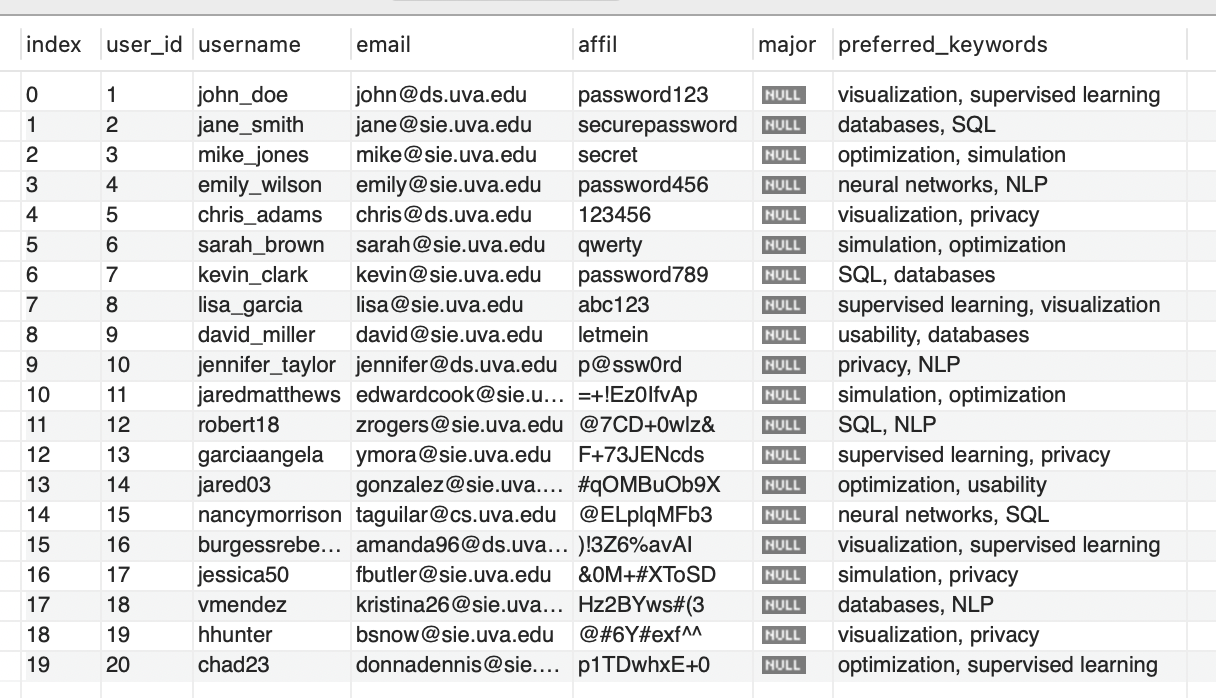

In [11]:
# extract the part between '@' and '.uva' using .extract() function
# ([^.]+) -> capturing group (e.g. ds, sie, cs, ...)
# \.uva -> matches the literal string .uva
user_df['major'] = user_df['email'].str.extract(r'@([^.]+)\.uva')

In [12]:
user_df
user_df = user_df.iloc[:, 1:]

In [13]:
# update user table
user_df.to_sql(con= db_engine, name= 'user', if_exists = 'replace')

20

#### 2. Next is about textual_review and ratings tables.

In [14]:
# fetch the textual_review and rating table from online_learning_platform database
text_review_df = pd.read_sql("SELECT * FROM online_learning_platform.textual_review", sqlEngine)
rating_review_df = pd.read_sql("SELECT * FROM online_learning_platform.rating", sqlEngine)

In [15]:
# Check how each looks like
print(text_review_df.head())
print(rating_review_df.head())

# check shapes -> do they have same number of rows?
print(text_review_df.shape)
print(rating_review_df.shape)

# check which column should be the key
print(text_review_df.columns)
print(rating_review_df.columns)

# print(text_review_df['feedback_id'])
# print(rating_review_df['feedback_id'])

   index  feedback_id                                            comment  \
0      0          1.0  Thorough explanation of system concepts, loved...   
1      1          2.0  Found the UI design principles too abstract wi...   
2      2          3.0  Quizzes helped reinforce key concepts, very us...   
3      3          4.0  Excellent machine learning coverage, but could...   
4      4          5.0  Lectures were engaging, especially the guest s...   

   user_id  course_id     date  
0      1.0     1001.0  2/11/25  
1      2.0     3035.0  4/11/24  
2      3.0     2202.0   3/4/25  
3      4.0     1001.0  6/22/24  
4      5.0     3035.0  9/16/24  
   index  feedback_id   binary  rating       datetime  user_id  course_id
0      0            1     like       4  2/11/25 12:15        1       1001
1      1            2  dislike       2   4/11/24 4:03        2       3035
2      2            3     like       4   3/4/25 22:14        3       2202
3      3            4     like       4   6/22/24 

In [16]:
# current text_review_df's 'feedback_id' data type is float. Let's convert into integer
text_review_df['feedback_id'] = text_review_df[['feedback_id']].fillna(value=0).astype(int)
text_review_df['feedback_id']

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      9
8     10
9     11
10    12
11    14
12    17
13    18
14    19
15    21
16    22
17    23
18    24
19    25
20    26
21    28
22    29
23    30
24    31
25    32
26    34
27    35
28    36
29    37
30    38
31    39
32    40
33    41
34    42
35    43
36    44
37    45
38     0
Name: feedback_id, dtype: int64

In [17]:
# let's combine two tables into one dataframe on ['feedback_id', 'user_id', 'course_id']
combined_feedback = pd.merge(text_review_df, rating_review_df, on=['feedback_id', 'user_id', 'course_id'], how = 'outer')
combined_feedback.head()

,index_x,feedback_id,comment,user_id,course_id,date,index_y,binary,rating,datetime
0,0.0,1,"Thorough explanation of system concepts, loved...",1.0,1001.0,2/11/25,0.0,like,4.0,2/11/25 12:15
1,1.0,2,Found the UI design principles too abstract wi...,2.0,3035.0,4/11/24,1.0,dislike,2.0,4/11/24 4:03
2,2.0,3,"Quizzes helped reinforce key concepts, very us...",3.0,2202.0,3/4/25,2.0,like,4.0,3/4/25 22:14
3,3.0,4,"Excellent machine learning coverage, but could...",4.0,1001.0,6/22/24,3.0,like,4.0,6/22/24 3:05
4,4.0,5,"Lectures were engaging, especially the guest s...",5.0,3035.0,9/16/24,4.0,like,4.0,9/16/24 3:59


In [18]:
# remove index_x and index_y
combined_feedback = combined_feedback.drop(columns=['index_x', 'index_y'])
# combined_feedback.head()

# convert user_id, course_id's data type into integer
combined_feedback['user_id'] = combined_feedback['user_id'].fillna(value=0).astype(int)
combined_feedback['course_id'] = combined_feedback['course_id'].fillna(value=0).astype(int)
combined_feedback.head()

,feedback_id,comment,user_id,course_id,date,binary,rating,datetime
0,1,"Thorough explanation of system concepts, loved...",1,1001,2/11/25,like,4.0,2/11/25 12:15
1,2,Found the UI design principles too abstract wi...,2,3035,4/11/24,dislike,2.0,4/11/24 4:03
2,3,"Quizzes helped reinforce key concepts, very us...",3,2202,3/4/25,like,4.0,3/4/25 22:14
3,4,"Excellent machine learning coverage, but could...",4,1001,6/22/24,like,4.0,6/22/24 3:05
4,5,"Lectures were engaging, especially the guest s...",5,3035,9/16/24,like,4.0,9/16/24 3:59


In [19]:
# extract time from datetime and set it in 'time' column
# combined_feedback.dtypes

combined_feedback['datetime'] = pd.to_datetime(combined_feedback['datetime'])
combined_feedback.dtypes

feedback_id             int64
comment                object
user_id                 int64
course_id               int64
date                   object
binary                 object
rating                float64
datetime       datetime64[ns]
dtype: object

In [20]:
# Remove unnecessary row (where feedback_id is 0. It doesn't make sense because it is started from 1.)
combined_feedback = combined_feedback[combined_feedback['feedback_id'] != 0]
combined_feedback

,feedback_id,comment,user_id,course_id,date,binary,rating,datetime
0,1,"Thorough explanation of system concepts, loved...",1,1001,2/11/25,like,4.0,2025-02-11 12:15:00
1,2,Found the UI design principles too abstract wi...,2,3035,4/11/24,dislike,2.0,2024-04-11 04:03:00
2,3,"Quizzes helped reinforce key concepts, very us...",3,2202,3/4/25,like,4.0,2025-03-04 22:14:00
3,4,"Excellent machine learning coverage, but could...",4,1001,6/22/24,like,4.0,2024-06-22 03:05:00
4,5,"Lectures were engaging, especially the guest s...",5,3035,9/16/24,like,4.0,2024-09-16 03:59:00
5,6,"Appreciated the visualization techniques, but ...",6,2202,3/4/25,like,5.0,2025-03-04 19:09:00
6,7,UI design course exceeded my expectations. Lov...,7,1001,2/7/25,like,5.0,2025-02-07 03:15:00
7,9,"System engineering lecture was a bit dry, but ...",9,2202,12/22/24,like,5.0,2024-12-22 22:55:00
8,10,"Big data analytics topics were useful, but som...",10,1001,12/14/24,like,5.0,2024-12-14 02:19:00
9,11,Very insightful discussion on design patterns ...,3,3035,1/27/25,like,5.0,2025-01-27 16:07:00


In [21]:
# for binary rating column, fill it based on the ratings. If rating>3, set it as 'like', otherwise, 'dislike'.
combined_feedback.loc[combined_feedback['rating'] > 3, 'binary'] = 'like'
combined_feedback.loc[combined_feedback['rating'] <= 3, 'binary'] = 'dislike'

# for 'date' column, extract only date from datetime and fill missing values
combined_feedback.loc[combined_feedback['date'].isna(), 'date'] = combined_feedback['datetime'].dt.date

# Make the date format consistent
combined_feedback['date'] = pd.to_datetime(combined_feedback['date'])

# fill comment column's missing value with 'NA'
combined_feedback['comment'] = combined_feedback['comment'].fillna('NA')
combined_feedback

,feedback_id,comment,user_id,course_id,date,binary,rating,datetime
0,1,"Thorough explanation of system concepts, loved...",1,1001,2025-02-11,like,4.0,2025-02-11 12:15:00
1,2,Found the UI design principles too abstract wi...,2,3035,2024-04-11,dislike,2.0,2024-04-11 04:03:00
2,3,"Quizzes helped reinforce key concepts, very us...",3,2202,2025-03-04,like,4.0,2025-03-04 22:14:00
3,4,"Excellent machine learning coverage, but could...",4,1001,2024-06-22,like,4.0,2024-06-22 03:05:00
4,5,"Lectures were engaging, especially the guest s...",5,3035,2024-09-16,like,4.0,2024-09-16 03:59:00
5,6,"Appreciated the visualization techniques, but ...",6,2202,2025-03-04,like,5.0,2025-03-04 19:09:00
6,7,UI design course exceeded my expectations. Lov...,7,1001,2025-02-07,like,5.0,2025-02-07 03:15:00
7,9,"System engineering lecture was a bit dry, but ...",9,2202,2024-12-22,like,5.0,2024-12-22 22:55:00
8,10,"Big data analytics topics were useful, but som...",10,1001,2024-12-14,like,5.0,2024-12-14 02:19:00
9,11,Very insightful discussion on design patterns ...,3,3035,2025-01-27,like,5.0,2025-01-27 16:07:00


In [22]:
# Add the content of the combined_feedback dataframe to a new table called feedback in the database
combined_feedback.to_sql(con= db_engine, name= 'feedback', if_exists = 'replace')

44

In [23]:
# Check current schema of the database
pd.read_sql("SHOW TABLES FROM online_learning_platform", sqlEngine)

,Tables_in_online_learning_platform
0,course
1,enrollment
2,feedback
3,rating
4,textual_review
5,user


### 4. Close the connection with the MySQL database

In [24]:
# keep in mind to close the connection
sql_connection.close()
sqlEngine.dispose()
db_engine.dispose()

print ("Connection closed.")

Connection closed.
